In [13]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append("./..")

from data import PollenDataset

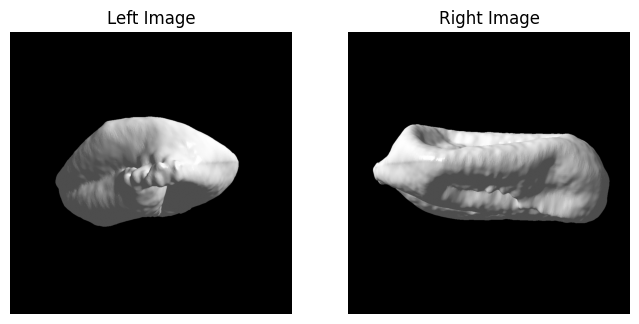

In [14]:
dataset = PollenDataset(image_transforms=transforms.ToTensor())

(left_img, right_img), (vertices, faces) = dataset[0]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(left_img.permute(1,2,0), cmap='gray')
plt.title("Left Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(right_img.permute(1,2,0), cmap='gray')
plt.title("Right Image")
plt.axis("off")
plt.show()

In [15]:
def lookat(camera_position, target, up):
    """
    Compute the camera extrinsic matrix (R|t) given a camera position, target, and up vector.
    """
    camera_position = np.array(camera_position)
    target = np.array(target)
    up = np.array(up)

    forward = target - camera_position
    forward /= np.linalg.norm(forward)
    right = np.cross(up, forward)
    right /= np.linalg.norm(right)
    true_up = np.cross(forward, right)
    
    # Rotation matrix (camera coordinate system)
    R = np.vstack([right, true_up, forward])
    t = -R @ camera_position
    RT = np.hstack([R, t.reshape(-1, 1)])
    return RT

def get_intrinsic(f, image_width, image_height):
    """
    Create an intrinsic matrix with focal length f and principal point at the image center.
    """
    cx = image_width / 2
    cy = image_height / 2
    K = np.array([[f, 0, cx],
                  [0, f, cy],
                  [0, 0, 1]])
    return K

def project_voxels(voxels, K, RT):
    """
    Project 3D points (voxels) into 2D image coordinates.
    - voxels: (N, 3) numpy array.
    - K: (3, 3) intrinsic matrix.
    - RT: (3, 4) extrinsic matrix.
    Returns an (N, 2) array with pixel coordinates.
    """
    N = voxels.shape[0]
    ones = np.ones((N, 1))
    voxels_hom = np.hstack([voxels, ones]).T  # shape (4, N)
    proj = K @ (RT @ voxels_hom)  # shape (3, N)
    proj /= proj[2, :]  # normalize homogeneous coordinate
    return proj[:2, :].T  # shape (N, 2)


In [20]:
# Define camera parameters
target = np.array([0, 0, 0])
up = np.array([0, 0, 1])

# Left camera positioned at (-1, 0, 0)
left_cam_position = [-1.0, 0.0, 0.0]
RT_left = lookat(left_cam_position, target, up)

# Right camera positioned at (1, 0, 0)
right_cam_position = [1.0, 0.0, 0.0]
RT_right = lookat(right_cam_position, target, up)

# Assume a focal length; here we choose f = 1.0 for simplicity.
# Use one of the sample images to set image dimensions.
print(left_img.squeeze(0).shape)
image_height, image_width = left_img.squeeze(0).shape
K = get_intrinsic(f=1.0, image_width=image_width, image_height=image_height)


torch.Size([1024, 1024])
